<a href="https://colab.research.google.com/github/lahirunie-dulsara/EN3150-Assignment-3-CNN/blob/Aazir/RealWaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile, os, re, shutil
from PIL import Image

zip_path = "/content/drive/MyDrive/Pattern Recognition/realwaste.zip"

extract_path = "/content"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipped to:", extract_path)


Unzipped to: /content


In [3]:
base_dir = "/content/realwaste-main/RealWaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Food Organics: 411 images
Glass: 420 images
Paper: 500 images
Metal: 790 images
Plastic: 921 images
Cardboard: 461 images
Vegetation: 436 images
Miscellaneous Trash: 495 images
Textile Trash: 318 images


In [4]:
pip install split-folders

In [5]:
import splitfolders  # install with: pip install split-folders

input_folder = base_dir
output_folder = "/content/realwaste-main/RealWaste_split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 4752 files [00:04, 1150.47 files/s]


In [6]:
split_dir = output_folder

# Count images in each subfolder
for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dir, split)
    print(f"\n{split.upper()} SET")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))

        total += count
        print(f"  {cls}: {count} images")
    print(f" Total {split}: {total} images")


TRAIN SET
  Food Organics: 287 images
  Glass: 294 images
  Paper: 350 images
  Metal: 553 images
  Plastic: 644 images
  Cardboard: 322 images
  Vegetation: 305 images
  Miscellaneous Trash: 346 images
  Textile Trash: 222 images
 Total train: 3323 images

VAL SET
  Food Organics: 61 images
  Glass: 63 images
  Paper: 75 images
  Metal: 118 images
  Plastic: 138 images
  Cardboard: 69 images
  Vegetation: 65 images
  Miscellaneous Trash: 74 images
  Textile Trash: 47 images
 Total val: 710 images

TEST SET
  Food Organics: 63 images
  Glass: 63 images
  Paper: 75 images
  Metal: 119 images
  Plastic: 139 images
  Cardboard: 70 images
  Vegetation: 66 images
  Miscellaneous Trash: 75 images
  Textile Trash: 49 images
 Total test: 719 images


In [48]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np # Already imported later, but useful here
from tqdm import tqdm # For progress bars

# Define standard normalization parameters (e.g., ImageNet mean/std)
# Even for custom CNNs, normalization helps training stability.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # ADDED: Normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) # ADDED: Normalization
])

train_dataset = datasets.ImageFolder("/content/realwaste-main/RealWaste_split/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("/content/realwaste-main/RealWaste_split/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder("/content/realwaste-main/RealWaste_split/test", transform=val_test_transforms)

# Get number of classes and device early
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")

Using device: cuda
Number of classes: 9


In [49]:
# Assuming train_dataset, val_dataset, test_dataset are defined from Block 1

class_counts = np.bincount(train_dataset.targets)
print("Class counts:", class_counts)

# Compute class weights (inverse of frequency)
class_weights_tensor = 1. / torch.tensor(class_counts, dtype=torch.float)

# Ensure sample_weights are floats for the sampler
sample_weights = [class_weights_tensor[label].item() for label in train_dataset.targets]

print("Class counts per category:")
for cls, count in zip(train_dataset.classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\n Class weights (inverse of frequency):")
for cls, w in zip(train_dataset.classes, class_weights_tensor):
    print(f"  {cls:15s}: {w:.6f}")



Class counts: [322 287 294 553 346 350 644 222 305]
Class counts per category:
  Cardboard      : 322
  Food Organics  : 287
  Glass          : 294
  Metal          : 553
  Miscellaneous Trash: 346
  Paper          : 350
  Plastic        : 644
  Textile Trash  : 222
  Vegetation     : 305

 Class weights (inverse of frequency):
  Cardboard      : 0.003106
  Food Organics  : 0.003484
  Glass          : 0.003401
  Metal          : 0.001808
  Miscellaneous Trash: 0.002890
  Paper          : 0.002857
  Plastic        : 0.001553
  Textile Trash  : 0.004505
  Vegetation     : 0.003279


In [50]:
# Define a consistent BATCH_SIZE
BATCH_SIZE = 64 # Increased batch size

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler) # ADDED: num_workers
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # ADDED: val_loader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # ADDED: test_loader


print(f"\n WeightedRandomSampler created successfully!")
print(f" Total samples in epoch: {len(sample_weights)}")
print(f" Training Batch size: {train_loader.batch_size}")
print(f" Validation Batch size: {val_loader.batch_size}")
print(f" Total training batches per epoch: {len(train_loader)}")


 WeightedRandomSampler created successfully!
 Total samples in epoch: 3323
 Training Batch size: 64
 Validation Batch size: 64
 Total training batches per epoch: 52


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm # For progress bars during training
import matplotlib.pyplot as plt
import numpy as np
import copy # For creating models with identical initial weights

# Define the custom CNN model (WasteCNN)
class WasteCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()
        # Convolutional Layers with Batch Normalization and Max Pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Dynamically determine the size of the feature maps after convolutional layers
        self._to_linear = None
        self.calculate_flatten_size(224) # Assuming an input image size of 224x224

        # Fully Connected Layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.dropout = nn.Dropout(0.5) # Dropout for regularization
        self.fc2 = nn.Linear(256, num_classes) # Output layer

    def calculate_flatten_size(self, input_size):
        # Pass a dummy tensor through the convolutional layers to determine the flattened size
        with torch.no_grad():
            x = torch.zeros(1, 3, input_size, input_size)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        if self._to_linear is None:
          self._to_linear = x.view(x.size(0), -1).size(1)

        x = x.view(-1, self._to_linear) # Flatten the output
        x = self.dropout(F.relu(self.fc1(x))) # Apply dropout and ReLU to the first FC layer
        x = self.fc2(x) # Output layer (logits)
        return x

# Assuming num_classes and device are defined from previous steps
# e.g., num_classes = 9
# e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("WasteCNN model class defined and ready for use.")

WasteCNN model class defined and ready for use.


In [53]:
# Function to get a new model instance, optionally with identical initial weights
# For a fair comparison, all models should ideally start from the same initial random weights.
def get_fresh_model_for_comparison(num_classes, device, base_model_path='initial_model_weights.pth'):
    if not os.path.exists(base_model_path):
        # If no base model state exists, create one and save its initial state
        initial_model = WasteCNN(num_classes=num_classes).to(device)
        torch.save(initial_model.state_dict(), base_model_path)
        print(f"Created and saved initial model weights to {base_model_path}")
        return initial_model
    else:
        # Load the saved initial state into a new model instance
        new_model = WasteCNN(num_classes=num_classes).to(device)
        new_model.load_state_dict(torch.load(base_model_path))
        return new_model

# --- Define a generic Training Function for Optimizer Comparison ---
def run_optimizer_training_comparison(model_instance, optimizer_name, optimizer_obj, criterion_obj, scheduler_obj, num_epochs_comp, train_loader_comp, val_loader_comp, device_comp):
    print(f"\nTraining with {optimizer_name} for {num_epochs_comp} epochs...")

    current_train_losses = []
    current_train_accuracies = []
    current_val_losses = []
    current_val_accuracies = []

    best_val_acc_run = 0.0
    model_path_run = f'best_model_comparison_{optimizer_name.lower().replace(" ", "_").replace("-", "_")}.pth'

    for epoch in range(num_epochs_comp):
        # Training phase
        model_instance.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loop = tqdm(train_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)

            optimizer_obj.zero_grad() # Zero the parameter gradients
            outputs = model_instance(images) # Forward pass
            loss = criterion_obj(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer_obj.step() # Optimize

            running_loss += loss.item() * images.size(0) # Aggregate loss

            _, predicted = torch.max(outputs, 1) # Get predictions
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader_comp.dataset)
        epoch_train_accuracy = 100 * train_correct / train_total
        current_train_losses.append(epoch_train_loss)
        current_train_accuracies.append(epoch_train_accuracy)

        if scheduler_obj:
            scheduler_obj.step() # Update learning rate if a scheduler is provided

        # Validation phase
        model_instance.eval() # Set model to evaluation mode
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad(): # Disable gradient computation
            val_loop = tqdm(val_loader_comp, desc=f"Epoch {epoch+1}/{num_epochs_comp} ({optimizer_name} Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device_comp), labels.to(device_comp)
                outputs = model_instance(images)
                loss = criterion_obj(outputs, labels)
                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader_comp.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        current_val_losses.append(epoch_val_loss)
        current_val_accuracies.append(epoch_val_accuracy)

        print(f"  {optimizer_name} - Epoch [{epoch+1}/{num_epochs_comp}] "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.2f}%")

        if epoch_val_accuracy > best_val_acc_run:
            best_val_acc_run = epoch_val_accuracy
            torch.save(model_instance.state_dict(), model_path_run) # Save best model for current optimizer

    print(f"--- {optimizer_name} training finished. Best Val Accuracy: {best_val_acc_run:.2f}% ---")
    return current_train_losses, current_train_accuracies, current_val_losses, current_val_accuracies, model_path_run

print("Helper functions `get_fresh_model_for_comparison` and `run_optimizer_training_comparison` defined.")

Helper functions `get_fresh_model_for_comparison` and `run_optimizer_training_comparison` defined.


In [54]:
import torch, gc

torch.cuda.empty_cache()
gc.collect()

990

In [57]:
print("\n" + "="*50)
print("       Starting Optimizer Performance Comparison Training       ")
print("="*50 + "\n")

# Create a 'base' model to get initial weights that all comparison models will share.
# This ensures a fair comparison starting from the same random initialization.
_ = get_fresh_model_for_comparison(num_classes, device) # Call once to save the initial state

# --- Optimizer Configuration for Comparison ---
NUM_EPOCHS_COMP = 20 # Train for 20 epochs as specified in the assignment

# Common Loss Function
criterion_comp = nn.CrossEntropyLoss()

# 1. Adam Optimizer Configuration
model_adam_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
optimizer_adam_comp = optim.Adam(model_adam_comp.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_adam_comp = StepLR(optimizer_adam_comp, step_size=10, gamma=0.1)

# 2. Standard SGD Optimizer Configuration
model_sgd_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
# SGD often requires a higher learning rate compared to Adam.
optimizer_sgd_comp = optim.SGD(model_sgd_comp.parameters(), lr=0.01, weight_decay=1e-4)
scheduler_sgd_comp = StepLR(optimizer_sgd_comp, step_size=10, gamma=0.1)

# 3. SGD with Momentum Optimizer Configuration
model_sgd_momentum_comp = get_fresh_model_for_comparison(num_classes, device) # Load identical initial weights
# Common momentum value is 0.9.
optimizer_sgd_momentum_comp = optim.SGD(model_sgd_momentum_comp.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_sgd_momentum_comp = StepLR(optimizer_sgd_momentum_comp, step_size=10, gamma=0.1)

# --- Run Training for each Optimizer ---
adam_results = run_optimizer_training_comparison(
    model_adam_comp, "Adam", optimizer_adam_comp, criterion_comp, scheduler_adam_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
adam_train_losses, adam_train_accuracies, adam_val_losses, adam_val_accuracies, adam_comp_model_path = adam_results

sgd_results = run_optimizer_training_comparison(
    model_sgd_comp, "Standard SGD", optimizer_sgd_comp, criterion_comp, scheduler_sgd_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_train_losses, sgd_train_accuracies, sgd_val_losses, sgd_val_accuracies, sgd_comp_model_path = sgd_results

sgd_momentum_results = run_optimizer_training_comparison(
    model_sgd_momentum_comp, "SGD with Momentum", optimizer_sgd_momentum_comp, criterion_comp, scheduler_sgd_momentum_comp, NUM_EPOCHS_COMP, train_loader, val_loader, device
)
sgd_momentum_train_losses, sgd_momentum_train_accuracies, sgd_momentum_val_losses, sgd_momentum_val_accuracies, sgd_momentum_comp_model_path = sgd_momentum_results

print("\nOptimizer comparison training completed for all models.")


       Starting Optimizer Performance Comparison Training       


Training with Adam for 20 epochs...


  Adam - Epoch [1/20] Train Loss: 49.9518 | Train Acc: 11.53% | Val Loss: 2.1935 | Val Accuracy: 8.87%


  Adam - Epoch [2/20] Train Loss: 2.2102 | Train Acc: 11.19% | Val Loss: 2.2057 | Val Accuracy: 10.56%


  Adam - Epoch [3/20] Train Loss: 2.1964 | Train Acc: 11.41% | Val Loss: 2.2020 | Val Accuracy: 19.30%


  Adam - Epoch [4/20] Train Loss: 2.2286 | Train Acc: 10.53% | Val Loss: 2.1994 | Val Accuracy: 9.72%


  Adam - Epoch [5/20] Train Loss: 2.1993 | Train Acc: 10.14% | Val Loss: 2.2018 | Val Accuracy: 10.56%


  Adam - Epoch [6/20] Train Loss: 2.2033 | Train Acc: 10.35% | Val Loss: 2.2003 | Val Accuracy: 8.87%


  Adam - Epoch [7/20] Train Loss: 2.1994 | Train Acc: 11.04% | Val Loss: 2.2001 | Val Accuracy: 8.87%


KeyboardInterrupt: 

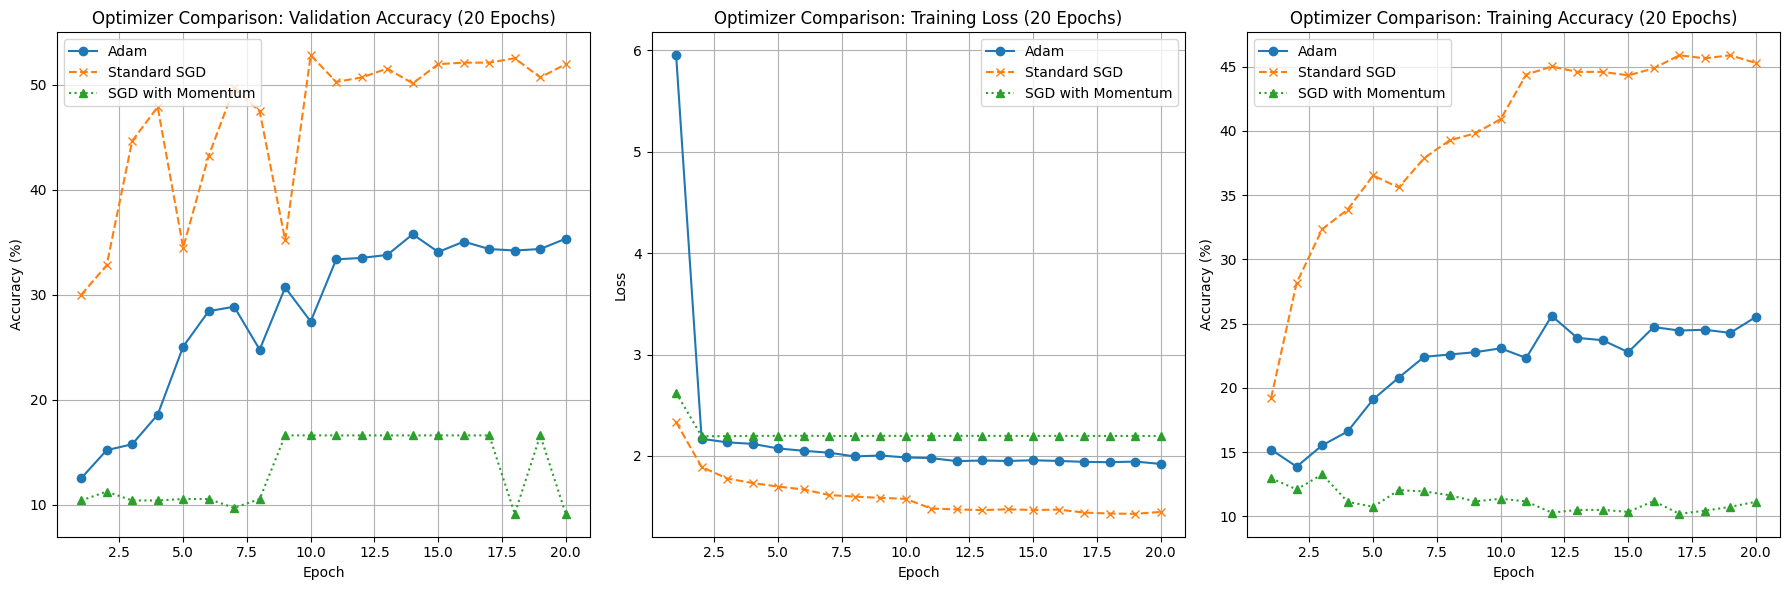


Optimizer Comparison plots generated.


In [ ]:
# --- Plotting Comparison ---
plt.figure(figsize=(18, 6))

# Plot Validation Accuracy Comparison
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_val_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_val_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_val_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Validation Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Plot Training Loss Comparison
plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_losses, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_losses, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_losses, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Training Loss ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Training Accuracy Comparison
plt.subplot(1, 3, 3)
plt.plot(range(1, NUM_EPOCHS_COMP + 1), adam_train_accuracies, marker='o', linestyle='-', label='Adam')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_train_accuracies, marker='x', linestyle='--', label='Standard SGD')
plt.plot(range(1, NUM_EPOCHS_COMP + 1), sgd_momentum_train_accuracies, marker='^', linestyle=':', label='SGD with Momentum')
plt.title(f"Optimizer Comparison: Training Accuracy ({NUM_EPOCHS_COMP} Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nOptimizer Comparison plots generated.")

In [ ]:
# --- Evaluate on Test Set Function for Comparison Models ---
def evaluate_on_test_set_comp(model_instance, model_path, test_loader_comp, device_comp):
    model_instance.load_state_dict(torch.load(model_path)) # Load the best weights
    model_instance.to(device_comp)
    model_instance.eval() # Set to evaluation mode

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_loop = tqdm(test_loader_comp, desc=f"Evaluating Test Set for model from {model_path}", leave=False)
        for images, labels in test_loop:
            images, labels = images.to(device_comp), labels.to(device_comp)
            outputs = model_instance(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    return test_accuracy

print("\n--- Evaluating Comparison Models on Test Set ---")

adam_final_test_accuracy = evaluate_on_test_set_comp(model_adam_comp, adam_comp_model_path, test_loader, device)
print(f"Adam (Comparison) Final Test Accuracy: {adam_final_test_accuracy:.2f}%")

sgd_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_comp, sgd_comp_model_path, test_loader, device)
print(f"Standard SGD (Comparison) Final Test Accuracy: {sgd_final_test_accuracy:.2f}%")

sgd_momentum_final_test_accuracy = evaluate_on_test_set_comp(model_sgd_momentum_comp, sgd_momentum_comp_model_path, test_loader, device)
print(f"SGD with Momentum (Comparison) Final Test Accuracy: {sgd_momentum_final_test_accuracy:.2f}%")

print("\n" + "="*50)
print("       Optimizer Performance Comparison Summary       ")
print("="*50 + "\n")
print(f"Final Test Accuracy for Adam: {adam_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for Standard SGD: {sgd_final_test_accuracy:.2f}%")
print(f"Final Test Accuracy for SGD with Momentum: {sgd_momentum_final_test_accuracy:.2f}%")
print("\nOptimizer Comparison Test Evaluation Complete.")


--- Evaluating Comparison Models on Test Set ---


Adam (Comparison) Final Test Accuracy: 35.74%


Standard SGD (Comparison) Final Test Accuracy: 52.29%


SGD with Momentum (Comparison) Final Test Accuracy: 16.55%

       Optimizer Performance Comparison Summary       

Final Test Accuracy for Adam: 35.74%
Final Test Accuracy for Standard SGD: 52.29%
Final Test Accuracy for SGD with Momentum: 16.55%

Optimizer Comparison Test Evaluation Complete.
